# Using DESC Interactively

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../../'))

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import PowerSeriesProfile
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces

DESC version 0.4.13+113.g8f18ca6.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 21.54 GB available memory


## Initializing an Equilibrium

Let's start with a simple example of a circular tokamak. We'll start by defining the boundary, which is represented by a double Fourier series for R and Z in terms of a poloidal angle $\theta$ and the geometric toroidal angle $\phi$. We specify the mode numbers for R and Z as 2d arrays of `[m,n]` pairs, and the coefficients as a 1d array.

**Note**: in DESC, radial modes are indexed by `l`, poloidal modes by `m`, and toroidal modes by `n`

In this case we'll use a major radius of 10 and a minor radius of 1, which gives the following surface:

In [3]:
surface = FourierRZToroidalSurface(R_lmn=[10, 1],
                                   modes_R=[[0, 0], [1,0]],
                                   Z_lmn=[0, 1],
                                   modes_Z=[[0,0], [-1, 0]],
                                  )

Next, we need to define the profiles. We'll take a vacuum case to start (pressure=0), and a simple quadratic $\iota$ profile. The profiles are given in terms a simple monic power series in powers of $\rho^l$:

In [4]:
pressure = PowerSeriesProfile(params=[0, 0, 0]) # this is a constant pressure of 0 
iota = PowerSeriesProfile(params=[1, 0, 1.5]) # iota = 1 + 1.5 r^2

Finally, we create an Equilibrium by giving it the surface and profiles, as well as specifying what resolution we want to use and a few other parameters:

In [5]:
eq = Equilibrium(surface=surface,
                 pressure=pressure,
                 iota=iota,
                 Psi=1.0, # flux (in Webers) within the last closed flux surface
                 NFP=1, # number of field periods
                 L=6, # radial spectral resolution
                 M=6, # poloidal spectral resolution
                 N=0, # toroidal spectral resolution (it's a tokamak so we don't need any toroidal modes)
                 L_grid=12, # real space radial resolution, slightly oversampled
                 M_grid=9, # real space poloidal resolution, slightly oversampled
                 N_grid=0, # real space toroidal resolution
                 sym=True, # explicitly enforce stellarator symmetry
                )

This automatically creates the spectral bases and generates an initial guess for the flux surfaces by scaling the boundary surface, which we can plot below:

## Plotting

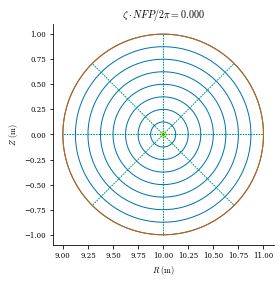

In [6]:
# plot_surfaces generates poincare plots of the flux surfaces
plot_surfaces(eq);

We can also look at the force balance error:

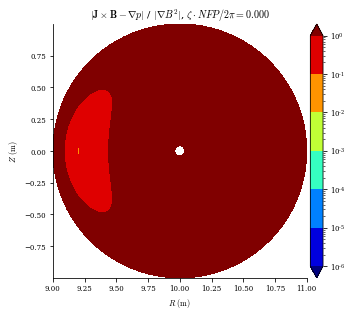

In [7]:
# plot_section plots various quantities on a toroidal cross section
# the second argument is a string telling it what to plot, in this case the force error density
# we could also look at B_z, (the toroidal magnetic field), or g (the coordinate jacobian) etc,
# here we also tell it to normalize the force error (relative to the magnetic pressure gradient or thermal pressure if present)
plot_section(eq,"|F|", norm_F=True, log=True);

We see that this is very far from an equilibrium. Let's try to fix that.

## Solving the Equilibrium

First, we need to give the equilibrium an objective that should be minimized, in this case we'll choose to minimize the force balance error. 

We also need to select an optimizer. Many options from `scipy.optimize` are available, as well as a few custom solvers that may be more efficient in some cases

In [8]:
eq.objective = "force"
eq.optimizer = "lsq-exact"

Next, we simply call `eq.solve()` to minimize the force balance error. Here we can also pass in arguments to the optimizer such as maximum number of iterations or stopping tolerances (we only run a few iterations here to show the idea). 

Under the hood, the objective function and its derivative are JIT compiled for the specific parameters we defined above before being passed to the optimizer.

In [9]:
eq.solve(verbose=2, ftol=1e-8);

Precomputing transforms
Timer: Precomputing transforms = 466 ms
Compiling objective function and derivatives
Timer: Objective compilation time = 1.22 sec
Timer: Jacobian compilation time = 3.59 sec
Timer: Total compilation time = 4.82 sec
Starting optimization
Optimization terminated successfully.
`xtol` condition satisfied.
         Current function value: 3.436e+05
         Iterations: 18
         Function evaluations: 19
         Jacobian evaluations: 19
Timer: Solution time = 445 ms
Timer: Avg time per step = 24.7 ms
Start of solver
Total residual:  5.196e+10  f_rho:  2.689e+05  f_beta:  1.778e+05
End of solver
Total residual:  3.436e+05  f_rho:  6.041e+02  f_beta:  5.676e+02


We can then look at the flux surfaces and force error again:

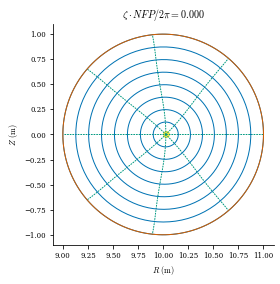

In [10]:
plot_surfaces(eq);

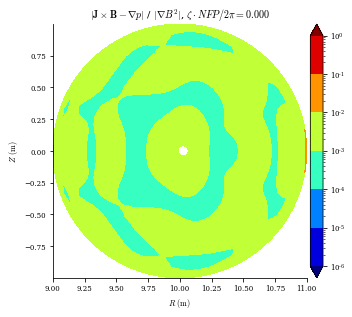

In [11]:
plot_section(eq,"|F|", norm_F=True, log=True);

## Perturbations

Next, we can ask "what would this equilibrium look like if we add pressure to it?"

We can answer this by applying a pressure perturbation to the current equilibrium. 

First, let's plot the pressure to make sure it's really zero:

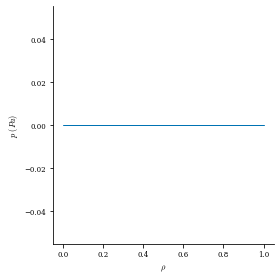

In [12]:
plot_1d(eq,"p");

Next, let's decide on how much we want to increase the pressure.

We'll give it a quadratic profile, peaked at 5000 Pascals in the core and dropping to 0 at the edge.

The perturbation is given in the same form the original profiles were (a power series in $\rho$)

In [13]:
delta_p = np.zeros_like(eq.p_l)
delta_p[0] = 1000.
delta_p[2] = -1000.


In [14]:
eq1 = eq.perturb(dp=delta_p, order=2)

Perturbing p_l
Precomputing Transforms
Factorizing boundary constraint
Computing df
Factoring df
Computing d^2f


Note that this gives us back a new equilibrium, so that the original is saved for future study. The new equilibrium keeps track of where it came from though, and the old equilibrium knows about the new one:

In [15]:
print("old == new: ",eq1 == eq)
print("new is child of old:", eq1 in eq.children)
print("old is parent of new:", eq1.parent is eq)

old == new:  False
new is child of old: True
old is parent of new: True


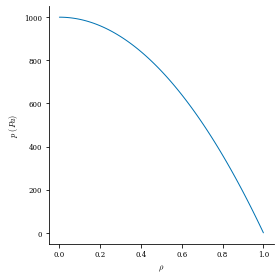

In [16]:
plot_1d(eq1,"p");

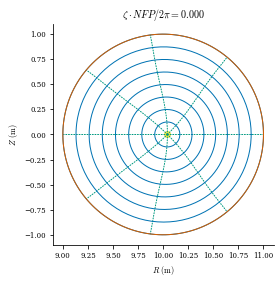

In [17]:
plot_surfaces(eq1);

Note the changes in the flux surface, and the slight outward movement of the axis

During the perturbation, the force error increased slightly, but still remains less than 10%

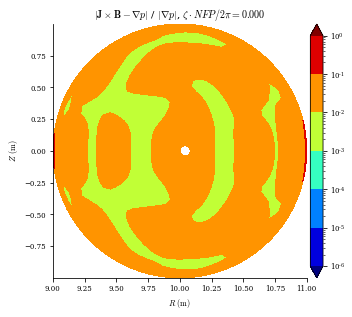

In [18]:
plot_section(eq1,"|F|", norm_F=True, log=True);

We can do a few Newton iterations to converge the solution again, this should go much faster than the initial solution

In [19]:
eq1.solve(verbose=2, ftol=1e-4);

Precomputing transforms
Timer: Precomputing transforms = 6.40 us
Compiling objective function and derivatives
Timer: Objective compilation time = 1.22 sec
Timer: Jacobian compilation time = 3.87 sec
Timer: Total compilation time = 5.09 sec
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 3.246e+04
         Iterations: 14
         Function evaluations: 16
         Jacobian evaluations: 15
Timer: Solution time = 137 ms
Timer: Avg time per step = 9.83 ms
Start of solver
Total residual:  1.979e+05  f_rho:  4.761e+02  f_beta:  4.112e+02
End of solver
Total residual:  3.246e+04  f_rho:  1.548e+02  f_beta:  2.023e+02


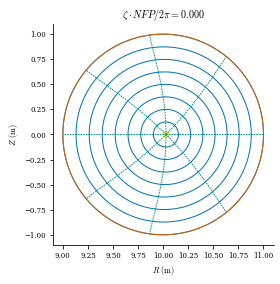

In [20]:
plot_surfaces(eq1);

Note that the flux surfaces and axis location only change by a tiny amout during the Newton iterations - the perturbation captured them accurately

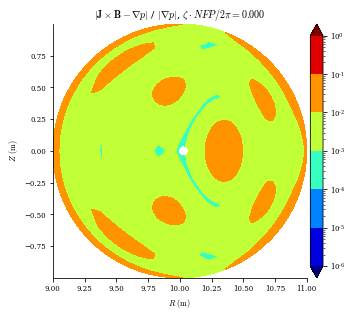

In [21]:
plot_section(eq1,"|F|", norm_F=True, log=True);

Next, we might want to try twisting our tokamak into a stellarator. We can accomplish this in a similar way, by applying a 3d boundary perturbation.

However, first we need to give our tokamak some non-axisymmetric modes in its spectral basis:

In [22]:
eq1.change_resolution(N=2,N_grid=3)

Now we can apply a 3d perturbation by perturbing the coefficients of the double Fourier series that defines the plasma boundary:

In [23]:
delta_R = np.zeros_like(eq1.Rb_lmn)
delta_Z = np.zeros_like(eq1.Zb_lmn)
delta_R[eq1.surface.R_basis.get_idx(M=1,N=1)] = -0.4
delta_Z[eq1.surface.Z_basis.get_idx(M=1,N=-1)] = -0.4

eq2 = eq1.perturb(dRb=delta_R, dZb=delta_Z,order=2)

Precomputing transforms
Perturbing Rb_lmn, Zb_lmn
Precomputing Transforms
Factorizing boundary constraint
Computing df
Factoring df
Computing d^2f


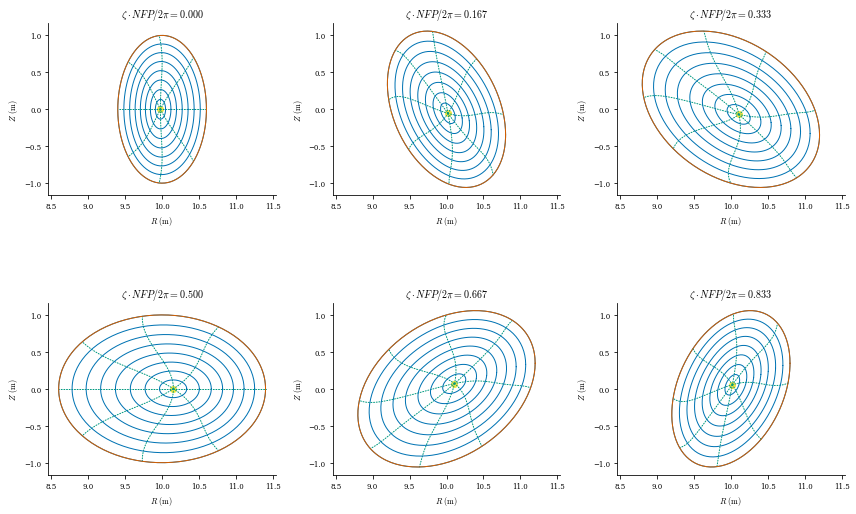

In [24]:
plot_surfaces(eq2);

Again, note that the force error increases after the perturbation. How much it increases depends on the "size" of the perturbation (note that due to the highly nonlinear equations, the "size" of the perturbation required to maintain force balance depends on the starting equilibrium as well as the actual delta).

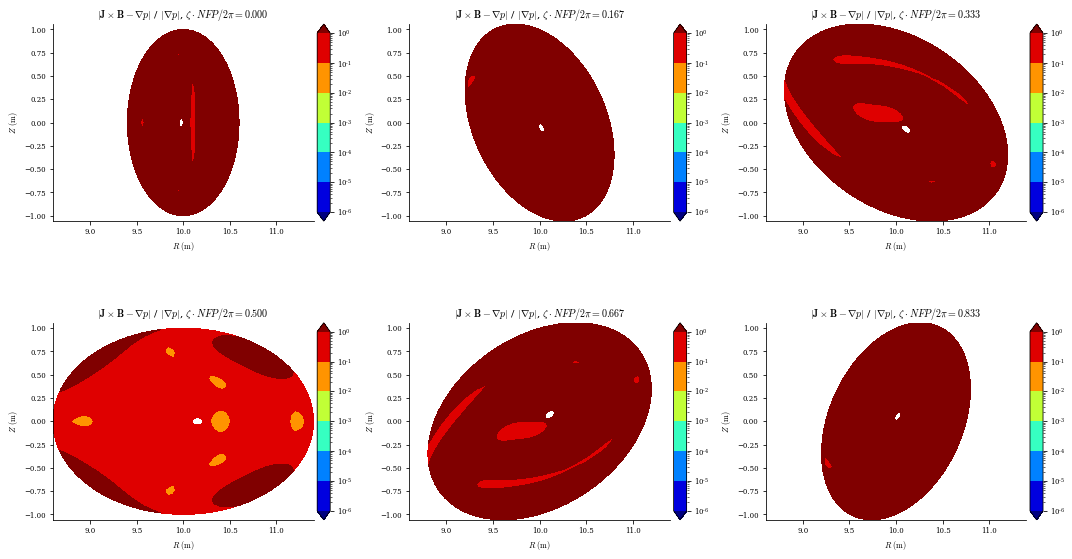

In [25]:
plot_section(eq2,"|F|", norm_F=True, log=True);

We can again run a few additional Newton iterations to improve the force balance error.

In [26]:
eq2.solve(verbose=2,ftol=1e-2);

Compiling objective function and derivatives
Timer: Objective compilation time = 1.07 ms
Timer: Jacobian compilation time = 46.6 ms
Timer: Total compilation time = 52.1 ms
Starting optimization
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 6.365e+04
         Iterations: 9
         Function evaluations: 12
         Jacobian evaluations: 10
Timer: Solution time = 1.24 sec
Timer: Avg time per step = 138 ms
Start of solver
Total residual:  1.582e+10  f_rho:  1.709e+05  f_beta:  4.942e+04
End of solver
Total residual:  6.365e+04  f_rho:  2.036e+02  f_beta:  2.930e+02


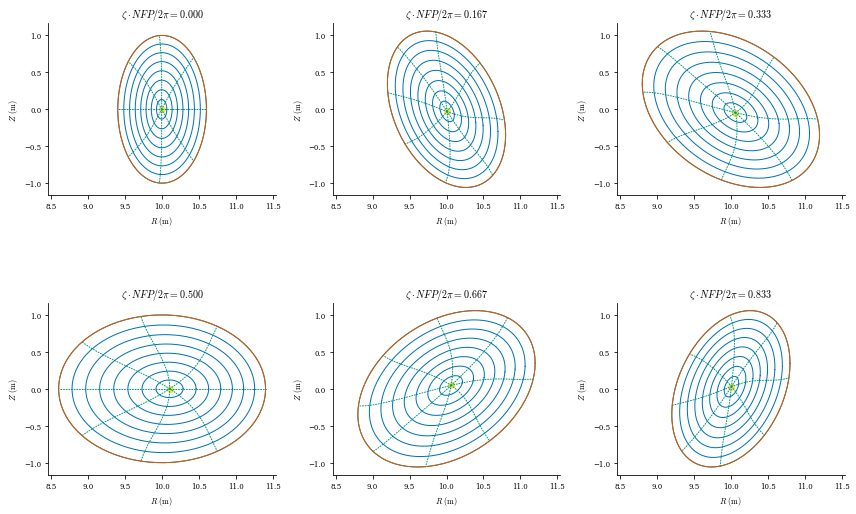

In [27]:
plot_surfaces(eq2);

Note again how the flux surfaces remain very similar, as the perturbation captures them accurately. Additional Newton iterations primarily serve to reduce the force error

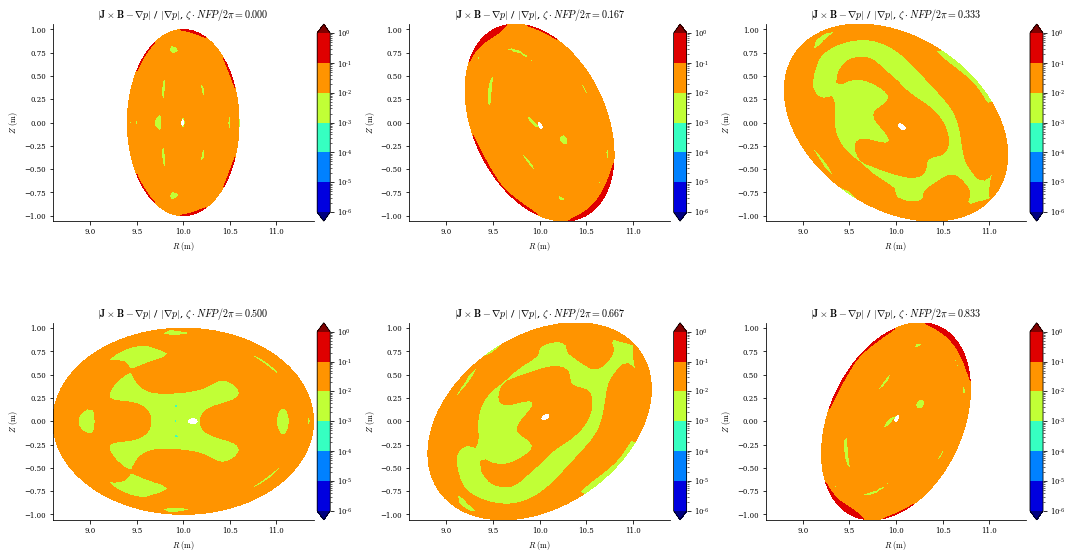

In [28]:
plot_section(eq2,"|F|", norm_F=True, log=True);

Note that even after additional Newton iterations, the force error is still rather high (between 1% and 10% throughout most of the volume). This is because the resolution we used was rather low, meant to be a quick demonstration rather than a realistic high quality solution. As DESC uses a pseudo-spectral discretization, increasing the resolution should decrease the error roughly exponentially.